# Phase resolved spectroscopy of Type C QPO toy dataset

## Loading dataset

In [1]:
import astropy
from astropy.table import Table
from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum, DynamicalPowerspectrum, Crossspectrum, AveragedCrossspectrum
from astropy.modeling import models, fitting
from stingray.modeling.scripts import fit_powerspectrum, fit_lorentzians, fit_crossspectrum
from scipy.stats import binned_statistic
from scipy.fftpack import fft, ifft
from scipy import optimize

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
type_c = "./toy_TypeC_lightcurve.fits"

lc_fits = Table.read(type_c)
meta = lc_fits.meta
print(lc_fits.info())
print(meta)
dt = meta['DT']
n_bins = meta['N_BINS']
n_seg = meta['N_SEG']
n_seconds = meta['NSECONDS']
n_chans = meta['DETCHANS']
lc_fits

<Table length=8192>
name  dtype   shape   unit             description           
---- ------- ------- ------ ---------------------------------
 REF float64   (50,) ct / s       Reference band light curves
  CI float64 (5, 50) ct / s Channels of interest light curves
None
OrderedDict([('N_BINS', 8192), ('DT', 0.0078125), ('DETCHANS', 5), ('CHBIN', '/Users/abbie/Documents/GitHub/gsoc18/epoch5_chbinfile.txt'), ('N_SEG', 50), ('NSECONDS', 64.0), ('INFILE', "['tlist_1.fits']"), ('OBJECT', 'GX_339-4')])


REF [50],"CI [5,50]"
ct / s,ct / s
float64,float64
1280.0 .. 896.0,256.0 .. 128.0
384.0 .. 896.0,896.0 .. 128.0
768.0 .. 640.0,640.0 .. 384.0
256.0 .. 1280.0,128.0 .. 640.0
768.0 .. 1024.0,256.0 .. 384.0
768.0 .. 896.0,384.0 .. 256.0
768.0 .. 640.0,128.0 .. 256.0
1408.0 .. 768.0,0.0 .. 256.0


In [3]:
# multiply dt to get counts
ref = np.asarray(lc_fits['REF'].T * dt, dtype=np.float64)
ci = np.asarray(lc_fits['CI'].T * dt, dtype=np.float64)
print(ref.shape, ci.shape)

# get counts in ref and ci bands
ref_counts = np.hstack(ref)
ci_counts = np.hstack(ci)
print(ref_counts.shape, ci_counts.shape)

(50, 8192) (50, 5, 8192)
(409600,) (5, 409600)


## Plotting light curve and averaged power spectrum of reference band

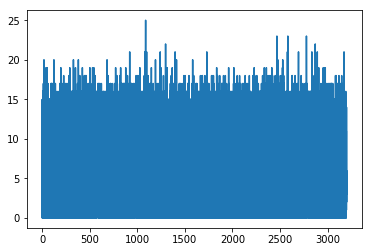

In [4]:
# rearranging reference band segments
ref_counts = np.hstack(ref)
ref_times = np.arange(0, n_seconds*n_seg, dt)

# plotting reference band lightcurve
ref_lc = Lightcurve(ref_times, ref_counts, dt=dt)
ref_lc.plot()

In [5]:
# plotting power spectrum of reference band
ref_aps = AveragedPowerspectrum(ref_lc, norm='leahy', segment_size=n_seconds) # absolute normalisation

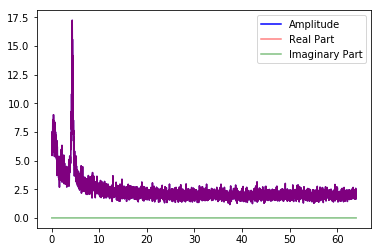

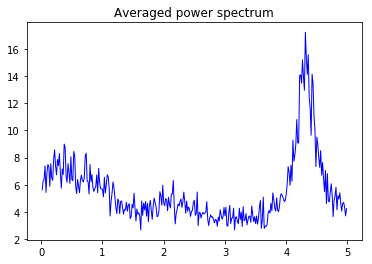

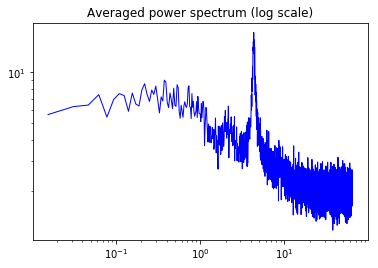

In [6]:
n = len(ref_aps.freq)
range_start, range_stop = int(0*n/64), int(5*n/64)

ref_aps.plot()

plt.figure()
plt.title("Averaged power spectrum")
plt.plot(ref_aps.freq[range_start:range_stop], np.abs(ref_aps.power)[range_start:range_stop], lw=1, color='blue')

plt.figure()
plt.title("Averaged power spectrum (log scale)")
plt.loglog(ref_aps.freq, np.abs(ref_aps.power), lw=1, color='blue')

## Fitting Lorentzian models
1. Two lorentzians (one for each component)
2. 1 Power Law (soft?)
3. Constant

[10.74462355  4.33953249  0.43681415  0.47843206  8.76563334  0.59350324
  2.04488907  2.22386829  0.53180417  1.55006239]


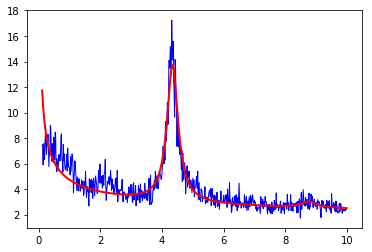

In [7]:
model_to_test = models.Lorentz1D(amplitude=12, x_0=4.3, fwhm=3.4) + models.Lorentz1D(x_0=9, amplitude=0.8, fwhm=2.) + models.PowerLaw1D(amplitude=0.1, x_0=1.5, alpha=0.8) + models.Const1D()

parest, res = fit_powerspectrum(ref_aps, model_to_test, fitmethod="CG")
res_model, res_pars = res.model, res.model.parameters

res_model_0 = res_model

# print(res_model)
print(res_pars)

n = len(ref_aps.freq)
range_start, range_stop = int(0.1*n/64), int(10*n/64)

plt.figure()
plt.plot(ref_aps.freq[range_start:range_stop], np.abs(ref_aps.power)[range_start:range_stop], lw=1, color='blue')
plt.plot(ref_aps.freq[range_start:range_stop], np.abs(res_model(ref_aps.freq))[range_start:range_stop], lw=2, color="red")

### Determining new N

In [8]:
def nearest_power_of_2(x):
    """
    Return a number which is nearest to `x` and is the integral power of two.

    Parameters
    ----------
    x : int, float

    Returns
    -------
    x_nearest : int
        Number closest to `x` and is the integral power of two.

    """
    x = int(x)
    x_lower = 1 if x == 0 else 2**(x - 2).bit_length()
    x_upper = 1 if x == 0 else 2**(x - 1).bit_length()
    x_nearest = x_lower if (x - x_lower) < (x_upper - x) else x_upper
    return x_nearest

In [9]:
fwhm = res_model[0].fwhm.value

new_n_bins = nearest_power_of_2(1/(fwhm*dt))
new_n_seg = int(n_bins*n_seg/new_n_bins)

df_old = 1/(n_bins*dt)
df_new = fwhm

dt_new = 1/(new_n_bins*df_new)
print("current N:", n_bins)
print("new N:", new_n_bins)
print("current M:", n_seg)
print("new M:", new_n_seg)
print("old df:", df_old)
print("new df:", df_new)
print("new dt:", dt_new)

current N: 8192
new N: 512
current M: 50
new M: 800
old df: 0.015625
new df: 0.43681414927190315
new dt: 0.004471295179552988


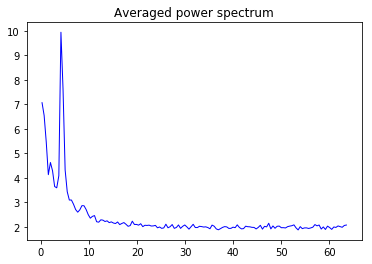

In [10]:
# plotting power spectrum of reference band
ref_aps_new = ref_aps.rebin(df=df_new)

n = len(ref_aps_new.freq)
range_start, range_stop = int(0*n/64), int(64*n/64)

plt.figure()
plt.title("Averaged power spectrum")
plt.plot(ref_aps_new.freq[range_start:range_stop], (np.abs(ref_aps_new.power))[range_start:range_stop], lw=1, color='blue')

[9.25953466 4.33565659 0.5665531  0.43281481 8.79616125 0.93611941
 1.94692713 2.08787047 0.62304633 1.68122407]


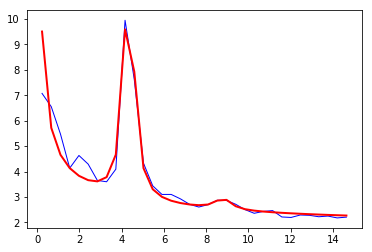

In [11]:
model_to_test = models.Lorentz1D(amplitude=12, x_0=4.3, fwhm=3.4) + models.Lorentz1D(x_0=9, amplitude=0.8, fwhm=2.) + models.PowerLaw1D(amplitude=0.1, x_0=1.5, alpha=0.8) + models.Const1D()

parest, res = fit_powerspectrum(ref_aps_new, model_to_test, fitmethod="CG")
res_model_new, res_pars_new = res.model, res.model.parameters

# print(res_model_new)
print(res_model_new.parameters)

n = len(ref_aps_new.freq)
range_start, range_stop = int(0*n/64), int(15*n/64)

plt.figure()
plt.plot(ref_aps_new.freq[range_start:range_stop], np.abs(ref_aps_new.power)[range_start:range_stop], lw=1, color='blue')
plt.plot(ref_aps_new.freq[range_start:range_stop], np.abs(res_model_new(ref_aps_new.freq))[range_start:range_stop], lw=2, color="red")

In [12]:
def calculate_rms(ps, model):
    """
    Return the rms of power spectrum where frequency is non-negative.

    Parameters
    ----------
    ps : Powerspectrum
        A Powerspectrum object.

    model: astropy.modeling.models class instance
        The parametric model supposed to represent the data. For details
        see the astropy.modeling documentation

    Returns
    -------
    rms : float
        RMS of the power spectrum.

    """
    freq = ps.freq # replace this with self.freq later
    model_output = model(freq>=0) # paper: "the integral from zero to infinity of a Lorentzian component gives the squared rms in that component"
    df = freq[1]-freq[0]
    rms = np.sqrt(np.sum(model_output * df))
    return rms

### Phase Difference

In [13]:
def find_nearest(array, value):
    """
    Return the array value that is closest to the input value (Abigail Stevens: Thanks StackOverflow!)

    Parameters
    ----------
    array : np.array of ints or floats
        1-D array of numbers to search through. Should already be sorted
        from low values to high values.

    value : int or float
        The value you want to find the closest to in the array.

    Returns
    -------
    array[idx] : int or float
        The array value that is closest to the input value.

    idx : int
        The index of the array of the closest value.

    """
    idx = np.searchsorted(array, value, side="left")
    if idx == len(array) or np.fabs(value - array[idx - 1]) < \
        np.fabs(value - array[idx]):
        return array[idx - 1], idx - 1
    else:
        return array[idx], idx

In [14]:
def get_parameters(counts, dt, model):
    """
    Return the array value that is closest to the input value (Abigail Stevens: Thanks StackOverflow!)

    Parameters
    ----------
    counts : np.array of ints or floats
        1-D array of numbers to search through. Should already be sorted
        from low values to high values.

    dt : float
        Time resolution of the light curve.
    
    model: astropy.modeling.models class instance
        The parametric model supposed to represent the data. For details
        see the astropy.modeling documentation. It assumes the first model
        is Lorentzian model fit at QPO component (fundamental) and the
        next Lorentzian model fit at the second harmonic.

    Returns
    -------
    mu : float
        Mean count rate of light curve.

    cap_phi_1 : float
        Phase offset of the first harmonic.

    cap_phi_2 : float
        Phase offset of the second harmonic.

    small_psi : float
        Phase difference between the first and second harmonics.

    """
    x = counts/dt
    X = fft(x) # fourier transform of count rate

    n = X.size
    timestep = dt
    ffreq = np.fft.fftfreq(n, d=timestep)

    x_0_0 = model[0].x_0.value
    x_0_1 = model[1].x_0.value

    _, idx_0 = find_nearest(ffreq, x_0_0)
    _, idx_1 = find_nearest(ffreq, x_0_1)

    X_1 = X[idx_0] # 1st harmonic
    X_2 = X[idx_1] # 2nd harmonic

    small_psi_1 = np.angle(X_1)
    small_psi_2 = np.angle(X_2)

    cap_phi_1 = small_psi_1
    cap_phi_2 = small_psi_2
    
    mu = np.mean(x)
    small_psi = (cap_phi_2/2 - cap_phi_1) % np.pi
    
    return mu, cap_phi_1, cap_phi_2, small_psi

In [15]:
avg_sigma_1 = calculate_rms(ref_aps_new, res_model_new[0]) # 1st harmonic Lorentzian
avg_sigma_2 = calculate_rms(ref_aps_new, res_model_new[1]) # 2nd harmonic Lorentzian

mu, cap_phi_1, cap_phi_2, small_psi = get_parameters(ref_counts, dt_new, res_model_new)

# QPO Waveform

In [16]:
def waveform(x, mu, avg_sigma_1, avg_sigma_2, cap_phi_1, cap_phi_2):
    """
    Return the QPO waveform (periodic function of QPO phase).

    Parameters
    ----------
    x : np.array of ints or floats
        QPO phase 

    mu : float
        Mean count rate of light curve.

    avg_sigma_1 : float
        Average RMS in the first harmonic.

    avg_sigma_2 : float
        Average RMS in the second harmonic.

    cap_phi_1 : float
        Phase offset of the first harmonic.

    cap_phi_2 : float
        Phase offset of the second harmonic.

    Returns
    -------
    y : np.array
        QPO waveform.

    """
    y = mu * (1 + np.sqrt(2) * (avg_sigma_1 * np.cos(x - cap_phi_1) + avg_sigma_2 * np.cos(2*x - cap_phi_2)))
    return y

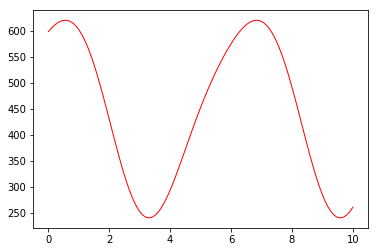

In [41]:
wave_x = np.linspace(0., 10., 100)
wave_y_avg = waveform(wave_x, mu, avg_sigma_1, avg_sigma_2, cap_phi_1, cap_phi_2)

plt.figure()
plt.plot(wave_x, wave_y_avg, lw=1, color='red')

## Calculating Error

In [42]:
ref_counts_seg = np.array_split(ref_counts, new_n_seg)

wave_ys = np.array([])

for i in range(new_n_seg): # for each segment
    # light curve and power spectrum
    ref_counts_seg_i = ref_counts_seg[i]
    ref_times_seg = np.arange(0, len(ref_counts_seg_i)*dt, dt)

    # plotting reference band lightcurve
    ref_lc_seg = Lightcurve(ref_times_seg, ref_counts_seg_i, dt=dt)
    ref_ps_seg = Powerspectrum(ref_lc_seg, norm='leahy')

    # calculation of parameters
    avg_sigma_1, avg_sigma_2
    mu, cap_phi_1, cap_phi_2, small_psi = get_parameters(ref_counts_seg_i, dt_new, res_model_new)
    
    # waveform
    wave_y = waveform(wave_x, mu, avg_sigma_1, avg_sigma_2, cap_phi_1, cap_phi_2)

    if i == 0:
        wave_ys = np.hstack((wave_ys, np.array(wave_y)))
    else:
        wave_ys = np.vstack((wave_ys, np.array(wave_y)))

In [43]:
def standard_error(xs, mean):
    """
    Return the standard error of the mean (SEM).

    Parameters
    ----------
    xs : 2-d float array
        List of data point arrays.

    mean : 1-d float array
        Average of the data points.

    Returns
    -------
    standard_error : 1-d float array
        Standard error of the mean (SEM).

    """
    n_seg = len(xs)
    
    xs_diff_sq = np.subtract(xs, mean)**2
    standard_deviation = np.sum(xs_diff_sq, axis=0) / (n_seg-1)
    standard_error = np.sqrt(standard_deviation / n_seg)

    return standard_error

In [44]:
error = standard_error(wave_ys, wave_y_avg)
error

array([47.40638293, 47.05710258, 46.72205414, 46.41095675, 46.13453642,
       45.90402997, 45.73065388, 45.62507   , 45.59688015, 45.65417819,
       45.80318159, 46.04795552, 46.3902329 , 46.82932487, 47.36211061,
       47.98309292, 48.6845075 , 49.45647754, 50.28720986, 51.16323272,
       52.06967729, 52.99060422, 53.90937412, 54.80905683, 55.67286961,
       56.48463064, 57.22921076, 57.89296517, 58.46412651, 58.93314222,
       59.29294141, 59.53912009, 59.67003722, 59.68681819, 59.59326637,
       59.39568683, 59.10262959, 58.72456243, 58.27348495, 57.76249729,
       57.20533785, 56.61590487, 56.0077777 , 55.39375402, 54.78542019,
       54.19277232, 53.62390605, 53.08479204, 52.57915236, 52.1084488 ,
       51.67198878, 51.26714723, 50.88969511, 50.53421745, 50.1945972 ,
       49.86453642, 49.53808405, 49.21013934, 48.8769018 , 48.53624278,
       48.18797783, 47.83402524, 47.47844166, 47.12733242, 46.78864049,
       46.47182468, 46.18744457, 45.94667537, 45.76078139, 45.64

# Phase Resolving Method

In [21]:
ci_counts_0 = ci_counts[0] # Choosing channel 1

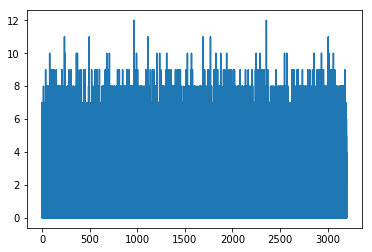

In [22]:
ci_times = np.arange(0, n_seconds*n_seg, dt)

# plotting CoI band lightcurve
ci_lc = Lightcurve(ci_times, ci_counts_0, dt=dt)
ci_lc.plot()

In [23]:
ci_aps = AveragedPowerspectrum(ci_lc, norm='leahy',segment_size=n_seconds) # absolute normalisation

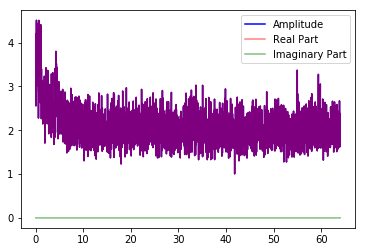

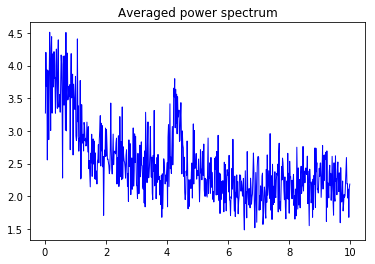

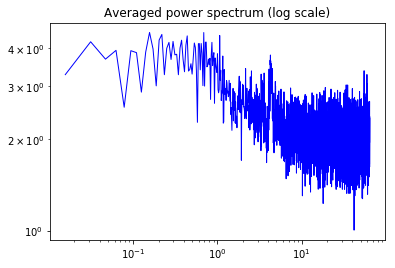

In [24]:
n = len(ci_aps.freq)
range_start, range_stop = int(0*n/64), int(10*n/64)

ci_aps.plot()

plt.figure()
plt.title("Averaged power spectrum")
plt.plot(ci_aps.freq[range_start:range_stop], np.abs(ci_aps.power)[range_start:range_stop], lw=1, color='blue')

plt.figure()
plt.title("Averaged power spectrum (log scale)")
plt.loglog(ci_aps.freq, np.abs(ci_aps.power), lw=1, color='blue')

[1.20133138 4.30640803 0.22535141 0.35206492 9.14247979 0.12494721
 0.90990487 1.32271935 0.44376329 1.78722384]


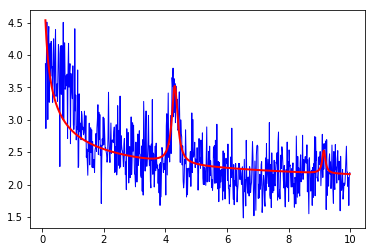

In [25]:
model_to_test = models.Lorentz1D(x_0=4.3) + models.Lorentz1D(x_0=9) + models.PowerLaw1D(x_0=1.5) + models.Const1D()
# model_to_test = models.Lorentz1D(amplitude=res_model_0[0].amplitude.value, x_0=res_model_0[0].x_0.value, fwhm=res_model_0[0].fwhm.value) + models.Lorentz1D(x_0=res_model_0[1].x_0.value, amplitude=res_model_0[1].amplitude.value, fwhm=res_model_0[1].fwhm.value) + models.PowerLaw1D(amplitude=res_model_0[2].amplitude.value, x_0=res_model_0[2].x_0.value, alpha=res_model_0[2].alpha.value) + models.Const1D()

parest, res = fit_powerspectrum(ci_aps, model_to_test, fitmethod="CG")
res_model, res_pars = res.model, res.model.parameters

ps_res_model = res_model # we'll use this later to calculate error

print(res_pars)

n = len(ref_aps.freq)
range_start, range_stop = int(0.1*n/64), int(10*n/64)

plt.figure()
plt.plot(ci_aps.freq[range_start:range_stop], np.abs(ci_aps.power)[range_start:range_stop], lw=1, color='blue')
plt.plot(ci_aps.freq[range_start:range_stop], np.abs(res_model(ci_aps.freq))[range_start:range_stop], lw=2, color="red")

In [26]:
fwhm = res_model[0].fwhm.value

new_n_bins = nearest_power_of_2(1/(fwhm*dt))
new_n_seg = int(n_bins*n_seg/new_n_bins)

df_old = 1/(n_bins*dt)
df_new = fwhm

dt_new = 1/(new_n_bins*df_new)
print("current N:", n_bins)
print("new N:", new_n_bins)
print("current M:", n_seg)
print("new M:", new_n_seg)
print("old df:", df_old)
print("new df:", df_new)
print("new dt:", dt_new)

current N: 8192
new N: 1024
current M: 50
new M: 400
old df: 0.015625
new df: 0.2253514149658215
new dt: 0.004333509510681851


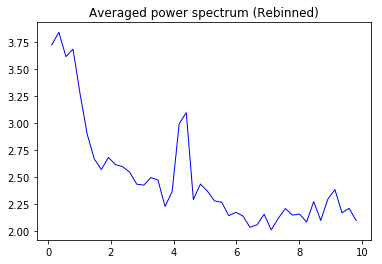

In [27]:
# plotting power spectrum of reference band
ci_aps_new = ci_aps.rebin(df=df_new)

n = len(ci_aps_new.freq)
range_start, range_stop = int(0*n/64), int(10*n/64)

plt.figure()
plt.title("Averaged power spectrum (Rebinned)")
plt.plot(ci_aps_new.freq[range_start:range_stop], (np.abs(ci_aps_new.power))[range_start:range_stop], lw=1, color='blue')

In [28]:
avg_sigma_1 = calculate_rms(ci_aps_new, res_model_new[0]) # 1st harmonic Lorentzian
avg_sigma_2 = calculate_rms(ci_aps_new, res_model_new[1]) # 2nd harmonic Lorentzian

x = ci_counts_0/dt_new

mu = np.mean(x)

## Calculating lag

In [29]:
# CoI averaged cross spectrum
ci_acs = AveragedCrossspectrum(lc2=ci_lc, lc1=ref_lc, segment_size=n_seconds, norm='leahy', power_type="real") # add ampltiude = True param

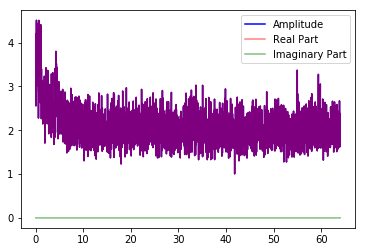

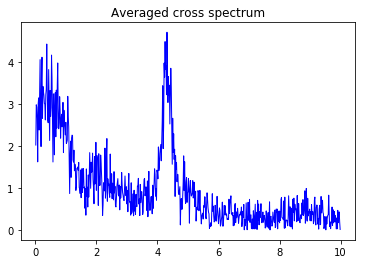

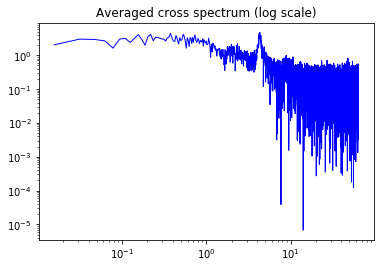

In [30]:
n = len(ci_acs.freq)
range_start, range_stop = int(0*n/64), int(10*n/64)

ci_aps.plot()

plt.figure()
plt.title("Averaged cross spectrum")
plt.plot(ci_acs.freq[range_start:range_stop], np.abs(ci_acs.power)[range_start:range_stop], lw=1, color='blue')

plt.figure()
plt.title("Averaged cross spectrum (log scale)")
plt.loglog(ci_acs.freq, np.abs(ci_acs.power), lw=1, color='blue')

In [31]:
def get_phase_lag(cs, model):
    """
    Return the phase offest of the waveform.

    Parameters
    ----------
    cs : Crossspectrum
        A Crossspectrum instance.

    model: astropy.modeling.models class instance
        The parametric model supposed to represent the data. For details
        see the astropy.modeling documentation. It assumes the first model
        is Lorentzian model fit at QPO component (fundamental) and the
        next Lorentzian model fit at the second harmonic.

    Returns
    -------
    cap_phi_1 : float
        Phase offset of the first harmonic.

    cap_phi_2 : float
        Phase offset of the second harmonic.

    small_psi : float
        Phase difference between the first and second harmonics.

    """
    x_0_0 = model[0].x_0.value
    x_0_1 = model[1].x_0.value

    _, idx_0 = find_nearest(cs.freq, x_0_0)
    _, idx_1 = find_nearest(cs.freq, x_0_1)
    
    C_E_1 = cs.power[idx_0] # 1st harmonic
    C_E_2 = cs.power[idx_1] # 2nd harmonic

    delta_E_1 = np.angle(C_E_1)
    delta_E_2 = np.angle(C_E_2)
    
    avg_psi, _ = get_mean_phase_difference(cs, model)

    cap_phi_1 = np.pi/2 + delta_E_1
    cap_phi_2 = 2*(cap_phi_1+avg_psi) + delta_E_2
    
    return cap_phi_1, cap_phi_2, avg_psi

In [32]:
def distance(avg_psi, psi):
    """
    Return the distance between array of phase differences of the segments and the mean phase difference.

    Parameters
    ----------
    avg_psi : float
        Mean phase difference between the first and second harmonics.

    psi: np.array of list of floats
        Phase difference of the segments.

    Returns
    -------
    dm : np.array

    """
    delta = np.abs(psi - avg_psi)
    dm = np.array([delta_i if avg_psi < np.pi/2 else np.pi - delta for delta_i in delta])
    return dm

In [33]:
def f(x, *args):
    """
    Function to minimise to find the average phase difference
    of the segements.
    """
    psi_m = np.array(args)
    X_2 = np.sum(distance(x, psi_m)**2)
    return X_2

In [34]:
def get_mean_phase_difference(cs, model):
    """
    Return the mean phase difference between the first and second harmonics.
    
    Parameters
    ----------
    cs : Crossspectrum
        A Crossspectrum instance.

    model : astropy.modeling.models class instance
        The parametric model supposed to represent the data. For details
        see the astropy.modeling documentation. It assumes the first model
        is Lorentzian model fit at QPO component (fundamental) and the
        next Lorentzian model fit at the second harmonic.

    Returns
    -------
    avg_psi : float
        Mean phase difference.
    
    stddev:
        Standard deviation on the mean.
    """
    counts = cs.lc1.counts #counts in CoI lightcurve
    dt = cs.lc2.dt # dt
    n_seg = cs.m # number of segments
    
    
    counts_seg = np.array_split(counts, n_seg) # splitting count rate array into segment
    
    small_psis = np.array([])
    
    for i in range(n_seg):
        counts_seg_i = counts_seg[i] # for each count segment
        
        _, _, _, small_psi_m = get_parameters(counts_seg_i, dt, model) # get phase offset between harmonics    
        small_psis = np.append(small_psis, small_psi_m)

    avg_psi, _, _, _ = optimize.brent(f, args=tuple(small_psis), full_output=True)
    
    stddev = avg_psi/n_seg

    return avg_psi, stddev

In [35]:
cap_phi_1, cap_phi_2, _ = get_phase_lag(ci_acs, res_model)

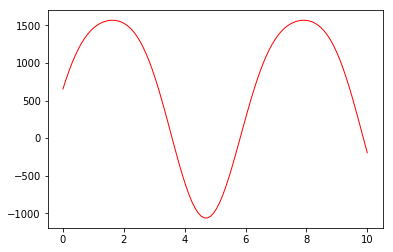

In [36]:
wave_x = np.linspace(0., 10., 100)
wave_y_avg = waveform(wave_x, mu, avg_sigma_1, avg_sigma_2, cap_phi_1, cap_phi_2)

plt.figure()
plt.plot(wave_x, wave_y_avg, lw=1, color='red')

## Calculating Error

In [37]:
ci_counts_seg = np.array_split(ci_counts_0, new_n_seg)
ref_counts_seg = np.array_split(ref_counts, new_n_seg)

wave_ys = np.array([])

for i in range(new_n_seg): # for each segment
    # light curve and power spectrum
    ref_counts_seg_i = ref_counts_seg[i]
    ci_counts_seg_i = ci_counts_seg[i]
    ref_times_seg = np.arange(0, len(ref_counts_seg_i)*dt, dt)
    ci_times_seg = np.arange(0, len(ci_counts_seg_i)*dt, dt)
    
    ref_lc_seg = Lightcurve(ref_times_seg, ref_counts_seg_i, dt=dt)
    ref_ps_seg = Powerspectrum(ref_lc_seg, norm='leahy')
    
    # df_new is not calculated again by fitting model because diffulty in fitting - plausible reason is noisy signal
    ref_ps_seg_new = ref_ps_seg.rebin(df=df_new)
    ci_lc_seg = Lightcurve(ci_times_seg, ci_counts_seg_i, dt=dt)
    ci_ps_seg = Powerspectrum(ci_lc_seg, norm='leahy')
    ci_ps_seg_new = ci_ps_seg.rebin(df=df_new)

    # calculation of parameters - here `ps_res_model` is fitted model on CoI averaged power spectrum
    avg_sigma_1 = calculate_rms(ci_ps_seg_new, ps_res_model[0]) # 1st harmonic Lorentzian
    avg_sigma_2 = calculate_rms(ci_ps_seg_new, ps_res_model[1]) # 2nd harmonic Lorentzian

    x = ci_counts_seg_i/dt_new
    mu = np.mean(x)

    ci_acs_seg = Crossspectrum(lc2=ci_lc_seg, lc1=ref_lc_seg, norm='leahy', power_type="all") # add ampltiude = True param
  
    cap_phi_1, cap_phi_2, _ = get_phase_lag(ci_acs_seg, ps_res_model)

    # waveform
    wave_x = np.linspace(0., 10., 100)
    wave_y = waveform(wave_x, mu, avg_sigma_1, avg_sigma_2, cap_phi_1, cap_phi_2)

    if i == 0:
        wave_ys = np.hstack((wave_ys, np.array(wave_y)))
    else:
        wave_ys = np.vstack((wave_ys, np.array(wave_y)))
#     plt.figure()
#     plt.plot(wave_x, wave_y_avg, lw=1, color='red')

In [39]:
error = standard_error(wave_ys, wave_y_avg)
error

array([11.0437539 , 16.29270238, 21.43486045, 26.22129959, 30.56743682,
       34.44400724, 37.84926596, 40.79850812, 43.31833414, 45.44246182,
       47.20815371, 48.65299886, 49.81201535, 50.71512045, 51.38503926,
       51.8357221 , 52.07132776, 52.08581052, 51.86312612, 51.37804803,
       50.59756165, 49.48278193, 47.9913212 , 46.08002105, 43.70795935,
       40.83966008, 37.44849098, 33.52039197, 29.0585279 , 24.09091131,
       18.68872757, 13.03234531,  7.77794889,  6.13999164, 10.69209838,
       17.26445398, 24.29290546, 31.37590222, 38.30388523, 44.91420108,
       51.06263719, 56.61769189, 61.46081546, 65.48842742, 68.61434278,
       70.77204753, 71.91654635, 72.02562825, 71.1004637 , 69.16549522,
       66.26762446, 62.47473865, 57.87366296, 52.56768194, 46.67386487,
       40.32062381, 33.64643848, 26.80228069, 19.96646733, 13.41181239,
        7.87709907,  6.25885965, 10.0213395 , 15.21886505, 20.4126838 ,
       25.2811332 , 29.72045514, 33.69343103, 37.19383283, 40.23